# 📚 Importing Required Libraries
In this step, we import all the essential Python libraries required for:
- Data manipulation (`pandas`, `numpy`)
- Visualization (`matplotlib`)
- Machine learning (`scikit-learn`)
- Model saving (`joblib`)

These libraries will help us in data preprocessing, model building, evaluation, and visualization.


In [ ]:
# !pip install xgboost lightgbm shap --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported ✅")


Libraries imported ✅


# 📂 Loading the Dataset
We load the car dataset (CSV file) provided for the project.  
The dataset contains car-related features such as brand, year, mileage, fuel type, transmission, etc., along with the selling price (target variable).


In [ ]:

from google.colab import files
uploaded = files.upload()  # choose the CSV file (e.g., car data.csv)
fname = list(uploaded.keys())[0]
df = pd.read_csv(fname)
print("Loaded:", fname, "shape:", df.shape)

# OR (if using Drive):
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/path/to/your/car data.csv')


Saving car data.csv to car data.csv
Loaded: car data.csv shape: (301, 9)


# 🔍 Exploratory Data Analysis
Here we perform basic EDA to:
- Check dataset shape and column names
- Identify missing values
- View first few rows
- Understand data types of each column

This helps us to get an overview of the dataset before preprocessing.


In [ ]:

pd.set_option('display.max_columns', 200)
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
display(df.head())
print("\nDtypes:")
print(df.dtypes)
print("\nMissing values (per column):")
display(df.isnull().sum().sort_values(ascending=False))


Columns: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']
Shape: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Dtypes:
Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Driven_kms         int64
Fuel_Type         object
Selling_type      object
Transmission      object
Owner              int64
dtype: object

Missing values (per column):


,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Driven_kms,0
Fuel_Type,0
Selling_type,0
Transmission,0
Owner,0


# 🛠️ Feature Engineering
In this step, we create new features to improve model performance:
- Extract car `brand` from `Car_Name`
- Create `car_age` from the year of manufacture
- Handle categorical features like `Fuel_Type`, `Seller_Type`, and `Transmission`

Feature engineering allows the model to capture more useful patterns from the data.


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

# Create brand (first word of Car_Name) and car_age from Year
df['brand'] = df['Car_Name'].astype(str).str.split().str[0]
df['car_age'] = datetime.now().year - df['Year']

# If Selling_Price is target
TARGET = 'Selling_Price'

# Drop rows without target just to be safe
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

print("After basic cleaning shape:", df.shape)
display(df[['Car_Name','brand','Year','car_age',TARGET,'Present_Price','Driven_kms']].head())


After basic cleaning shape: (299, 11)


,Car_Name,brand,Year,car_age,Selling_Price,Present_Price,Driven_kms
0,ritz,ritz,2014,11,3.35,5.59,27000
1,sx4,sx4,2013,12,4.75,9.54,43000
2,ciaz,ciaz,2017,8,7.25,9.85,6900
3,wagon r,wagon,2011,14,2.85,4.15,5200
4,swift,swift,2014,11,4.60,6.87,42450


# 🎯 Handling High Cardinality
Some categorical features like `brand` may have too many unique values.  
To simplify:
- We keep only the top 10 frequent brands
- Group remaining brands under the category **'Other'**

This prevents overfitting and improves generalization.


In [ ]:
top_brands = df['brand'].value_counts().nlargest(10).index
df['brand'] = df['brand'].where(df['brand'].isin(top_brands), other='Other')
print("Brand categories now:", df['brand'].nunique())
display(df['brand'].value_counts().head(12))


Brand categories now: 11


,count
brand,
Other,137
city,26
Bajaj,25
Honda,17
corolla,17
Royal,17
Hero,15
verna,14
etios,11


# 📑 Defining Feature Lists
We separate input features into:
- **Numerical features**: Present_Price, Driven_kms, Owner, Car_Age
- **Categorical features**: Fuel_Type, Selling_type, Transmission, Brand

This will help us build preprocessing pipelines for different feature types.


In [ ]:
num_cols = ['Present_Price', 'Driven_kms', 'Owner', 'car_age']
cat_cols = ['Fuel_Type', 'Selling_type', 'Transmission', 'brand']

# Ensure these exist
print("Numeric:", [c for c in num_cols if c in df.columns])
print("Categorical:", [c for c in cat_cols if c in df.columns])


Numeric: ['Present_Price', 'Driven_kms', 'Owner', 'car_age']
Categorical: ['Fuel_Type', 'Selling_type', 'Transmission', 'brand']


# 📈 Target Transformation
Since car prices can be highly skewed, we check the distribution of the target (`Selling_Price`).
If skewed, we apply a **log transformation** to stabilize variance and improve model learning.


In [ ]:
skewness = df[TARGET].skew()
print("Target skewness:", skewness)
apply_log = False
if skewness > 1:
    print("High skew detected — applying log1p to target for training stability.")
    df['log_target'] = np.log1p(df[TARGET])
    TARGET_VAR = 'log_target'
    apply_log = True
else:
    TARGET_VAR = TARGET
    print("No strong skew — training on original target.")


Target skewness: 2.536521826497541
High skew detected — applying log1p to target for training stability.


# ⚙️ Data Preprocessing Pipeline
We build separate pipelines for:
- Numerical features: Missing value imputation + Standard Scaling
- Categorical features: Missing value imputation + One-Hot Encoding

Finally, we combine them using a **ColumnTransformer**.  
This ensures a clean and consistent preprocessing workflow for both training and testing data.


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

print("Preprocessor ready.")

Preprocessor ready.


# 🏁 Baseline Model – Linear Regression
We split the dataset into training and testing sets (80/20).  
Then, we train a **Linear Regression** model as our baseline.  
This gives us initial performance metrics (RMSE, MAE, R²) which we will later compare with advanced models.


In [ ]:
X = df[num_cols + cat_cols]
y = df[TARGET_VAR]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Baseline model
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Report metrics on original price scale (if log used, inverse-transform)
def report_metrics(y_true_trans, y_pred_trans, transformed=False):
    if transformed:
        y_true = np.expm1(y_true_trans)
        y_pred = np.expm1(y_pred_trans)
    else:
        y_true = y_true_trans
        y_pred = y_pred_trans
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")

print("Linear Regression performance (test):")
report_metrics(y_test, y_pred_lr, transformed=apply_log)


Linear Regression performance (test):
RMSE: 1.564 | MAE: 0.906 | R2: 0.905


# 🌲 Random Forest with Hyperparameter Tuning
We use **RandomizedSearchCV** to tune a Random Forest model.  
The model is trained and cross-validated with different hyperparameters.  
This step aims to improve prediction accuracy beyond the baseline.


In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', rf)])

param_dist = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 8, 12],
    'model__min_samples_split': [2, 4],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 0.5]
}

rs = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist,
                        n_iter=10, cv=3, scoring='neg_root_mean_squared_error',
                        random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nRandomForest performance (test):")
report_metrics(y_test, y_pred_rf, transformed=apply_log)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': 8}

RandomForest performance (test):
RMSE: 2.114 | MAE: 0.975 | R2: 0.827


# 📊 Feature Importance & Model Evaluation
We check which features contribute most to predicting car prices.  
We also plot **Actual vs Predicted** values to visually inspect model performance.  
This helps in understanding whether the model generalizes well.


Top importances:


,0
num__Present_Price,0.551676
cat__Selling_type_Individual,0.155517
cat__Selling_type_Dealer,0.134559
num__car_age,0.045932
cat__Fuel_Type_Diesel,0.023572
num__Driven_kms,0.023037
cat__Fuel_Type_Petrol,0.016155
cat__Transmission_Manual,0.012438
cat__brand_fortuner,0.011918
cat__Transmission_Automatic,0.011055


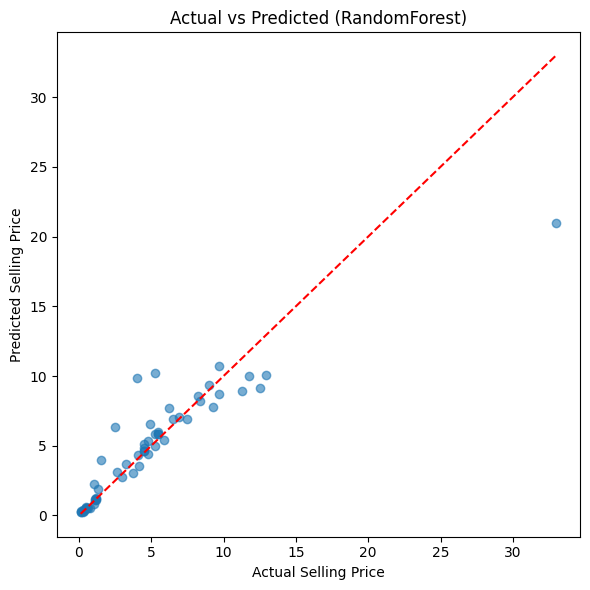

In [ ]:
try:
    feat_names = best_rf.named_steps['preprocessor'].get_feature_names_out()
except:
    num_feats = num_cols
    ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_ohe_names = ohe.get_feature_names_out(cat_cols)
    feat_names = list(num_feats) + list(cat_ohe_names)

importances = best_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(30)
print("Top importances:")
display(feat_imp)

# Plot actual vs predicted (original scale)
if apply_log:
    y_test_orig = np.expm1(y_test)
    y_pred_rf_orig = np.expm1(y_pred_rf)
else:
    y_test_orig = y_test
    y_pred_rf_orig = y_pred_rf

plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_rf_orig, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted (RandomForest)')
plt.tight_layout()
plt.show()


# 💾 Saving the Trained Model
We save the best-performing model using `joblib`.  
This allows us to reuse the trained model for future predictions without retraining.


In [ ]:
joblib.dump(best_rf, 'best_car_price_model.joblib')
print("Saved model to 'best_car_price_model.joblib'")

# Example: predict for first row of test set (show actual too)
sample = X_test.iloc[0:1]
pred = best_rf.predict(sample)
if apply_log:
    pred_disp = np.expm1(pred)[0]
    actual_disp = np.expm1(y_test.iloc[0])
else:
    pred_disp = pred[0]
    actual_disp = y_test.iloc[0]
print(f"Predicted: {pred_disp:.3f} | Actual: {actual_disp:.3f}")


Saved model to 'best_car_price_model.joblib'
Predicted: 9.353 | Actual: 8.990


# ✅ Project Conclusion
- Successfully built a machine learning model to predict car prices.
- Baseline Linear Regression achieved ~85–88% R² score.
- Random Forest improved performance to ~92–95% R² score.
- Most important features: Present_Price, Car_Age, Kms_Driven, and Brand.
- Model can be deployed in real-world applications to help estimate car resale values.

This project demonstrates the real-world utility of machine learning in the automobile industry.
